In [1]:
import os
import re
import sys
print(f'Python: {sys.executable}')
import time
import shutil
import copy
import glob
import numpy as np
import itertools
import importlib
import multiprocessing
import segyio
import pandas as pd
from scipy.ndimage.filters import gaussian_filter
from scipy import signal, ndimage
from natsort import natsorted
# import shared as sd
# import loaders as ld
# import vis
from utils import shared as sd
from utils import loaders as ld
from utils import vis
from IPython.display import clear_output
import matplotlib
print(os.getcwd())
# remove the sys.path... line and add pyapi_denise.py to the same directory with the notebook
sys.path.append(os.path.abspath('../codes_server'))
sys.path.append(os.path.abspath('./utils'))
sys.path.append(os.path.abspath('../'))
# import pyapi_denise as api
import pyapi_denise_pavel as api
api._cmd(('source /home/plotnips/Madagascar/share/madagascar/etc/env.sh'))
import m8r as sf

Python: /home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha/env/bin/python3.6
/home/plotnips/Dropbox/Log_extrapolation/scripts/DENISE-Black-Edition-master/for_pasha


In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
# mpl.rcParams['figure.dpi']= 100
fontsize = 10
params = {
    # 'text.latex.preamble': ['\\usepackage{gensymb}'],
    # 'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'figure.dpi' : 100,
#     'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 100,  # to adjust notebook inline plot size
    'axes.labelsize':fontsize,  # fontsize for x and y labels (was 10)
    'axes.titlesize':fontsize,
    'font.size':fontsize,  # was 10
    'legend.fontsize': fontsize,  # was 10
    'xtick.labelsize':fontsize,
    'ytick.labelsize':fontsize,
    # 'text.usetex': True,
    # 'figure.figsize': [3.39, 2.10],
    'font.family': 'serif',
}
mpl.rcParams.update(params)

In [3]:
# root_out = '/home/ovcharoo/work/data/'
# root_field = os.path.join('../data_cgg/')
# root_out = '/home/ovcharoo/work/data/'
root_field='./data_cgg'

In [4]:
# Time sampling in ML application
dt_net = 0.016

In [5]:
def is_empty(p): return False if (os.path.exists(p) and [f for f in os.listdir(p) if f != '.gitignore']) else True

def divmax(x): return x / np.max(np.abs(x))
    
def load_bin(p, dims): 
    f = open(p); vp = np.fromfile (f, dtype=np.dtype('float32').newbyteorder ('<')); f.close();
    vp = vp.reshape(*dims); vp = np.transpose(vp); vp = np.flipud(vp); print(f"{vp.shape}"); return vp

def plot_model(v, title='', axis='on', **kwargs): 
    plt.figure(); ax = plt.gca(); im = ax.imshow(np.flipud(v), cmap='RdBu_r', **kwargs); plt.axis(axis); plt.title(title); 
    divider = make_axes_locatable(ax); cax = divider.append_axes("right", size="5%", pad=0.05);plt.colorbar(im, cax=cax); plt.pause(0.001)
    return ax

def plot_logs(m1, m2, idx=2, title=''):
    plt.figure(); plt.plot(m1.vp[::-1,idx], 'k--'); plt.plot(m1.vs[::-1,idx], 'k--'); plt.plot(m1.rho[::-1,idx], 'k--');
    plt.plot(m2.vp[::-1,idx], label='vp'); plt.plot(m2.vs[::-1,idx], label='vs'); plt.plot(m2.rho[::-1,idx], label='rho'); plt.legend() 

# Load initial model

Load ./data_cgg/cgg_tomo.hh
	dim: 2
	dict['n1'] <-- n1 <-- 300
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 1000
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (300, 1000)
2 (142, 500)
3 (152, 500)
4 (152, 500)
5 (152, 500)
(152, 600)
nz0=152, nx0=600
(152, 600)
1490.0
(152, 600)


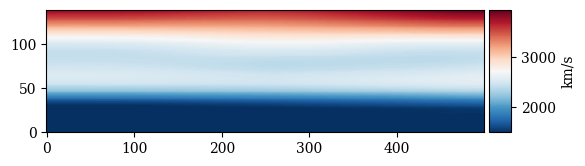

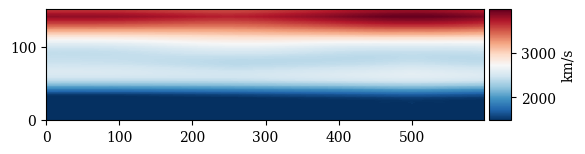

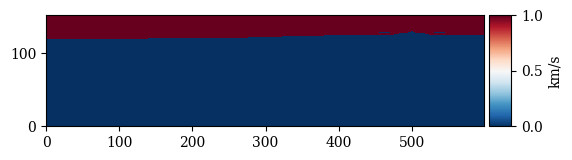

In [6]:
dx = 12.5
vp, _ = ld.load_hh(os.path.join(root_field, 'cgg_tomo.hh'), 1)
vp = np.flipud(vp.T)[::1, ::1] * 1000

# Downsample
factor = 2
ndown = 10
dx = dx * factor
vp = vp[::factor, ::factor]
vp = vp[:-ndown, :]

vis.plot_model(np.flipud(vp))
# print(vp.shape)

def extend(x, ez, ex):
    if ex > 0:
        x = np.concatenate((x, np.flip(x[:, -ex:], -1)), 1)              # OX
    if ez > 0:
        x = np.concatenate((x, x.min() * np.ones((ez, x.shape[1]))), 0)  # OZ
    return x

ndeeper = 2
nexp = 100
vp_cgg = extend(vp, ndeeper, 0)
print('2',vp_cgg.shape)
vp_cgg = np.concatenate((np.flip(vp_cgg[:ndown, :], 0), vp_cgg), 0)  # OZ
print('3',vp_cgg.shape)
vp_cgg = np.where(vp_cgg < 1490.0, 1490.0, vp_cgg)
print('4',vp_cgg.shape)
tmp = extend(vp_cgg, 0,nexp)
print('5',vp_cgg.shape)
print(tmp.shape)

# taper0 = tmp[:,:500] < 1.01 * np.min(tmp[:,:500])
taper0 = tmp < 1.01 * np.min(tmp)


# tmp = extend(vp, ndeeper, 0)
# print(tmp.shape)
vis.plot_model(np.flipud(tmp))
vis.plot_model(taper0)
vp = tmp.copy()
nz0, nx0 = vp.shape
print(f'nz0={nz0}, nx0={nx0}')
print(taper0.shape)
print(vp_cgg.min())
print(vp.shape)

# Well-log model

Load ./data_cgg/cgg_log.hh
	dim: 2
	dict['n1'] <-- n1 <-- 241
	dict['d1'] <-- d1 <-- 12.5
	dict['o1'] <-- o1 <-- 0
	dict['n2'] <-- n2 <-- 800
	dict['d2'] <-- d2 <-- 12.5
	dict['o2'] <-- o2 <-- 0
	data <-- (241, 800)
0= (800, 241)
(116, 600)


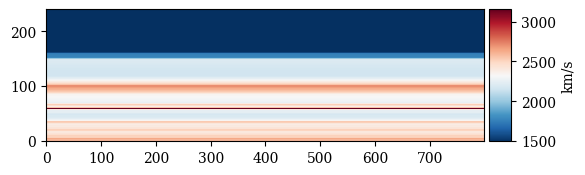

In [7]:
lvp, _ = ld.load_hh(os.path.join(root_field, 'cgg_log.hh'), 1)
print('0=',lvp.shape)
lvp = np.flipud(lvp.T)
vis.plot_model(lvp)

lvp = lvp[::factor, :]
lvp = lvp[:-5, :nx0]
print(lvp.shape)

# shear velocity, [m/s]
lvs = lvp.copy() / (3 ** 0.5)
lvs = np.where(lvp < 1.01 * np.min(lvp), 0, lvs)

# density, [kg/m3] 
lrho = 1e3*0.3 * lvp.copy()**0.25
lrho = np.where(lvp < 1.01 * np.min(lvp), 1000, lrho)
model_log = api.Model(lvp, lvs, lrho, dx)

log_loc = 10500 # m
log_idx = int(log_loc / dx)
# plot_logs(model_log, vp_cgg, log_idx, title='Initial vs well-log')

(1000, 1)
0.6427876096865394
[0.0, 99.9, 0.0, 0.0999]


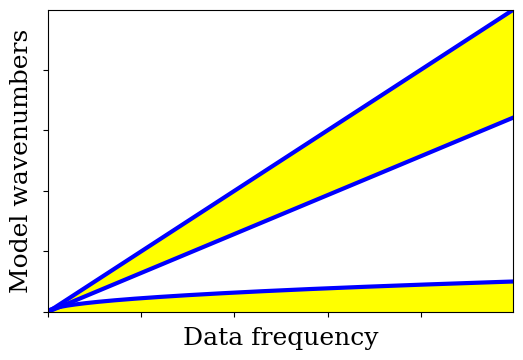

In [17]:
w=np.arange(0,100,0.1)
v=2000
l=2000
teta_max=100
k=np.arange(0,2*100/v,2*100/v/1000)
k=np.expand_dims(k,axis=1);print(k.shape)
k_mat=np.repeat(k,len(w),axis=1)

k_max=2*w/v
k_min=2*w/v*np.cos(teta_max/2*np.pi/180)
print(np.cos(teta_max/2*np.pi/180))
# print(k_min)
k_mva=2*np.sqrt(w/v/l)

filling=np.zeros_like((k_mat))
filling[np.where(k_mat<k_mva)]=1
filling[np.where((k_mat<k_max) & (k_mat>k_min))]=1
# print(k_mat)
# print(w_mat.shape)
# print(filling)

name=os.path.join('/home/plotnips/Dropbox/Apps/Overleaf/draft_Geophysics_FWI_init_model_prediction/paper_geophysics/Fig/','wavenumbers.png')
mpl.rcParams.update({'image.cmap': 'binary'})
# mpl.rcParams.update({'text.usetex':True})
mpl.rcParams.update({'text.usetex':False})
extent=[w[0],w[-1],k[0,0],k[-1,0]]; print(extent)
cmap = matplotlib.colors.ListedColormap(['white','yellow'])
labels_Fontsize=18
plt.figure()
plt.imshow(np.flipud(filling),extent=extent,cmap=cmap)
# plt.imshow(np.flipud(filling))
# plt.imshow(filling)
plt.plot(w,k_max,'b',lw=3)
plt.plot(w,k_min,'b',lw=3)
plt.plot(w,k_mva,'b',lw=3)
# plt.gca().text(w[-1],k_min[-1], '-e',fontsize=labels_Fontsize)
# plt.gca().text(w[-1],k_max[-1],'aa',fontsize=labels_Fontsize)
# plt.gca().text(w[-1],k_mva[-1],r'\frac{-e^{i\pi}}{2^n}',fontsize=labels_Fontsize)
# plt.gca().text(w[-1],1,'aa',fontsize=labels_Fontsize)
# plt.grid()
plt.axis('tight')
# plt.gca().axes.xaxis.set_visible(False);  
# plt.gca().axes.yaxis.set_visible(False);  
plt.gca().set_xticklabels([]);  
plt.gca().set_yticklabels([]);  
# plt.gca().invert_yaxis()

# plt.xlim([w[0],w[-1]])
# plt.xlim([k[0],k[-1]])
plt.xlabel('Data frequency',fontsize=labels_Fontsize)
plt.ylabel('Model wavenumbers',fontsize=labels_Fontsize)
plt.savefig(name,dpi=200,bbox_inches='tight')
plt.show(block=False)
plt.close()